In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics # # from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
base_df = pd.read_csv("../Data/clinvar_conflicting.csv", dtype={"CHROM": "string", "MOTIF_NAME": "string", "HIGH_INF_POS": "string"})

In [3]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  string 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [19]:
# reduce the data frame and do some basic cleaning, start with just a few bare features

#     - CHROM, REF, ALT, AF_*, CLNVC, ORIGIN, CLASS, Allele, Consequence, IMPACT, STRAND
# reduced_df = base_df[['CHROM', 'CLASS']]
# reduced_df = base_df[['CLASS', 'CHROM', 'REF']]
reduced_df = base_df[['CLASS', 'CHROM', 'REF', 'ALT']]

# fix chrom
reduced_df.loc[reduced_df['CHROM'] == 'X', 'CHROM'] = '23'
reduced_df.loc[reduced_df['CHROM'] == 'MT', 'CHROM'] = '24'
reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])

# print(reduced_df['CHROM'].unique())
# print(reduced_df['CHROM'].value_counts())

# dropping MT rows (after it was converted to 24)
# reduced_df.drop(reduced_df[reduced_df['CHROM'] == 24].index, inplace=True)

# drop rows where REF is not one of the main 4 (for others there are not many rows, could maybe combine them though in the future somehow)
# main_alleles = ['C', 'G', 'A', 'T']
# reduced_df = reduced_df[reduced_df['REF'].isin(main_alleles)]

# reduced_df["REF"] = reduced_df["REF"].astype(str)


# reduced_df.info()
# reduced_df[len(reduced_df['REF']) > 1] # = '2+'

reduced_df.loc[reduced_df['REF'].str.len() > 1, 'REF'] = '2+'
reduced_df.loc[reduced_df['ALT'].str.len() > 1, 'ALT'] = '2+'


print(reduced_df['ALT'].nunique())
with pd.option_context('display.max_rows', 2000):
    print(reduced_df['ALT'].value_counts())


# print(reduced_df['CLASS'].unique())
# print(reduced_df['CLASS'].value_counts())

5
T     20409
A     20205
G     11782
C     11429
2+     1363
Name: ALT, dtype: int64


<ipython-input-19-becd27cef1c6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])
/Users/NickPC/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/NickPC/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [23]:
# encode REF column 
encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT'], columns=['REF', 'ALT'])
encoded_df

,CLASS,CHROM,REF_2+,REF_A,REF_C,REF_G,REF_T,ALT_2+,ALT_A,ALT_C,ALT_G,ALT_T
0,0,1,0,0,0,1,0,0,0,1,0,0
1,0,1,0,0,0,1,0,0,1,0,0,0
2,1,1,0,1,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,1,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
65183,0,23,0,0,0,0,1,0,0,0,1,0
65184,1,23,0,0,1,0,0,0,0,0,0,1
65185,0,23,0,0,1,0,0,0,0,0,0,1
65186,0,23,0,0,0,0,1,0,0,1,0,0


In [ ]:
# need to do one-hot-encoding of allele type to turn it into a useful variable
# or can maybe use Pandas built in functions, Pandas.Categorical...

# reduced_df.loc[:, 'REF'] = reduced_df['REF'].astype('category')

# print(reduced_df['REF'].nunique())
# print(reduced_df['REF'].value_counts())

In [24]:
# split data into test and train sets
# df_train, df_test = train_test_split(reduced_df, test_size=0.2, random_state=55)
df_train, df_test = train_test_split(encoded_df, test_size=0.2, random_state=55)

In [ ]:
# sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');

In [ ]:
# sns.kdeplot(df_train['CHROM'], hue=df_train['CLASS'])
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [ ]:
# sns.countplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.countplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [ ]:
# counts = (df_train.groupby(['CLASS'])['CHROM']
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .mul(100)
#                      .reset_index()
#                      .sort_values('CHROM'))
# p = sns.barplot(x="CHROM", y="percentage", hue="CLASS", data=counts)

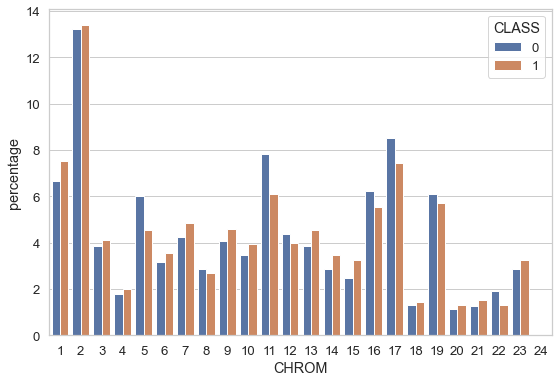

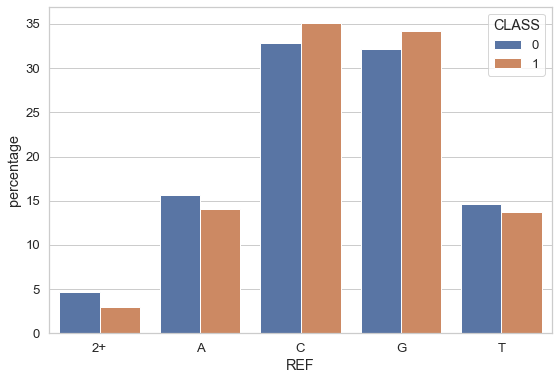

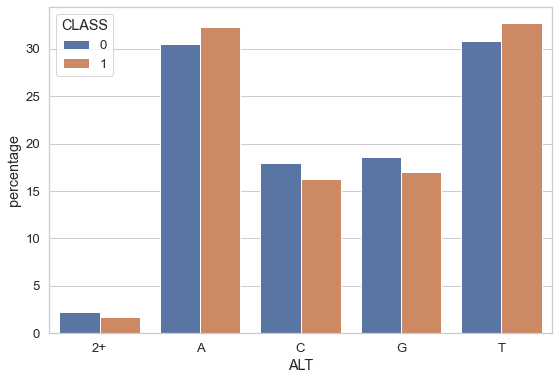

In [21]:
# check categorical variables vs conflicting or not to try and find some predictive features
for col in df_train.columns:
    if(col == 'CLASS'): continue
    plt.figure()
    counts = (df_train.groupby(['CLASS'])[col]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(col))
    sns.barplot(x=col, y="percentage", hue="CLASS", data=counts)


In [ ]:
stop

In [25]:
# split out features and target for models

x_train = df_train.drop('CLASS', axis=1)
y_train = df_train['CLASS']

In [ ]:
# lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
#                           C=100000)  # No regularization

# lm_1.fit(x_train, y_train)

In [ ]:
# print('intercept: ', round(lm_1.intercept_[0], 4))
# print('chrom coef: ', round(lm_1.coef_[0][0], 4))

In [ ]:
# df_eval = df_test.copy()
# df_eval['pred'] = lm_1.predict(x_train)
# df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
# df_eval['correct_pred'] = df_eval['pred'] == df_eval['CLASS']

In [ ]:
# df_eval.info()
# # df_eval.head(50)
# df_eval['pred'].unique()

In [ ]:
# sns.stripplot(data=df_eval,
#               x='CHROM',
#               y='pred',
#               hue='correct_pred',
#               palette={False: '#f03b20', True: '#3182bd'});

In [26]:
# check with dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(x_train)
dummy_clf.score(x_train, y_train)


0.7495877277085331

In [27]:
# try KNN with chrom still as numbers

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_train)

0.715378715244487


              precision    recall  f1-score   support

           0       0.75      0.92      0.83     39091
           1       0.29      0.09      0.14     13059

    accuracy                           0.72     52150
   macro avg       0.52      0.51      0.48     52150
weighted avg       0.64      0.72      0.66     52150



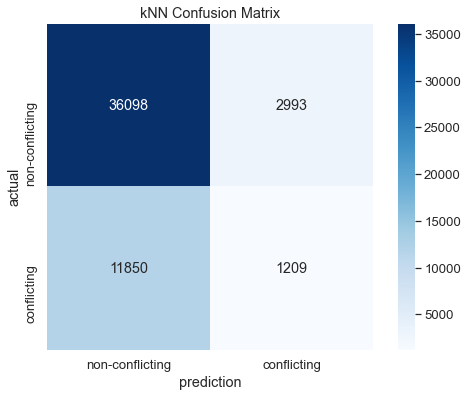

In [46]:
# print(metrics.accuracy_score(y_train, y_pred))
print(metrics.classification_report(y_train, y_pred))

conf_mat = metrics.confusion_matrix(y_train, y_pred)
# sns.heatmap(conf_mat)
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['non-conflicting', 'conflicting'],
           yticklabels=['non-conflicting', 'conflicting']);
plt.xlabel('prediction')
plt.ylabel('actual')
# plt.yticks(ticks="array-like")
plt.title("kNN Confusion Matrix");

In [34]:
# print(df_train.head(5))
# y_pred[:50]

In [35]:
# set_of_conf_chroms = set()
# for i, val in enumerate(y_pred):
#     if(val == 1):
#         set_of_conf_chroms.add(df_train.iloc[i]['CHROM'])
        
# #         print(df_train.iloc[[i]])
# #         print(y_pred[i])
# print(set_of_conf_chroms)